We use the matrix label code based parametriztion.


See [https://jmlr.org/papers/v25/23-1599.html](https://jmlr.org/papers/v25/23-1599.html)

and

[https://proceedings.mlr.press/v139/wang21u.html](https://proceedings.mlr.press/v139/wang21u.html)

The solver for hard-margin SVM is hosted at [https://github.com/YutongWangML/msvmpy](https://github.com/YutongWangML/msvmpy)

It requires `cvxopt`

In [1]:
!pip install git+https://github.com/YutongWangUMich/msvmpy.git

  Cloning https://github.com/YutongWangUMich/msvmpy.git to /tmp/pip-req-build-ow4wyr0j
  Running command git clone --filter=blob:none --quiet https://github.com/YutongWangUMich/msvmpy.git /tmp/pip-req-build-ow4wyr0j
  Resolved https://github.com/YutongWangUMich/msvmpy.git to commit ab11ca44fef75bbf770c1b9090a60b324e7077fc
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import msvmpy.hard_margin as hard_margin

In [3]:
def make_dataset(num_samples, num_classes, num_features, random_seed = None):
    if random_seed is not None:
        np.random.seed(random_seed)
    X = np.random.randn(num_samples,num_features)
    Wstar = np.random.randn(num_features,num_classes)      # ground truth classifier
    y = np.argmax(X@Wstar,axis=1)     # labels
    return X, y

In [4]:
def make_matrix_label_code(num_classes):
    ncm1 = num_classes - 1
    mlc = [np.eye(ncm1) for j in range(num_classes)]
    for j in range(ncm1):
        mlc[j][:,j] = -1
    return mlc

In [61]:
rng_seed = 6

def check_conjecture(num_samples, num_classes, num_features, num_trials = 100):
    """
    Construct num_trials many randomly generated datasets.
    """
    rng_seed = 0
    mlc = make_matrix_label_code(num_classes)
    while rng_seed < num_trials:
        X,y = make_dataset(num_samples,num_classes,num_features, random_seed = rng_seed)

        all_classes_appear =  len(np.unique(y)) == num_classes
        Wrmarg,dual_vars = hard_margin.FnormA_du_rmarg(X,y,num_classes)
        dual_vars = np.abs(dual_vars)

        dv = dual_vars.flatten()
        dv_sorted = -np.sort(-dv)
        ratios = dv_sorted[:-1]/dv_sorted[1:]

        # see "Explanation of num_SVs" section for the explanation of the calculation of the number of support vectors
        num_SVs = np.argmax(np.floor(np.log10(np.round(ratios,0).astype(int))).astype(int) > 0) + 1
        threshold = (dv_sorted[num_SVs-1]-dv_sorted[num_SVs])/2

        arr = dual_vars> threshold
        result = np.where(arr)

        indices_list = list(zip(result[0], result[1]))
        m_kron_x_list = [np.kron((mlc[y[i]].T)[:,j], X[i,:]) for i,j in indices_list]

        G = np.vstack(m_kron_x_list).T # The G matrix defined in Appendix H in the matrix label code paramatrization

        assert(G.shape  == ( num_features * (num_classes-1), num_SVs))

        assert(np.linalg.matrix_rank(G) == num_SVs)
        rng_seed += 1

    print("No counter-example found")
    return None

num_samples = 100
num_classes = 3
num_features = 2
num_trials = 100

In [62]:
for num_classes in [3,4,5,6]:
    for num_features in [2,3,4,5,6]:
        print(f"num_classes: {num_classes}, num_features: {num_features}")
        check_conjecture(num_samples = 20*num_classes, num_classes = num_classes, num_features = num_features, num_trials = 100)

num_classes: 3, num_features: 2
No counter-example found
num_classes: 3, num_features: 3
No counter-example found
num_classes: 3, num_features: 4
No counter-example found
num_classes: 3, num_features: 5
No counter-example found
num_classes: 3, num_features: 6
No counter-example found
num_classes: 4, num_features: 2
No counter-example found
num_classes: 4, num_features: 3
No counter-example found
num_classes: 4, num_features: 4
No counter-example found
num_classes: 4, num_features: 5
No counter-example found
num_classes: 4, num_features: 6
No counter-example found
num_classes: 5, num_features: 2
No counter-example found
num_classes: 5, num_features: 3
No counter-example found
num_classes: 5, num_features: 4
No counter-example found
num_classes: 5, num_features: 5
No counter-example found
num_classes: 5, num_features: 6
No counter-example found
num_classes: 6, num_features: 2
No counter-example found
num_classes: 6, num_features: 3
No counter-example found
num_classes: 6, num_features: 4

# Explanation for `num_SVs`

First, we calculate the dual variables (flattened) in descending order

In [63]:
rng_seed = 0
num_classes = 4
num_features = 4
num_samples = 20*num_classes
mlc = make_matrix_label_code(num_classes)
X,y = make_dataset(num_samples,num_classes,num_features, random_seed = rng_seed)

all_classes_appear =  len(np.unique(y)) == num_classes
Wrmarg,dual_vars = hard_margin.FnormA_du_rmarg(X,y,num_classes)
dual_vars = np.abs(dual_vars)

dv = dual_vars.flatten()
dv_sorted = -np.sort(-dv)

Now, let us plot them with logarithmic y-scale.

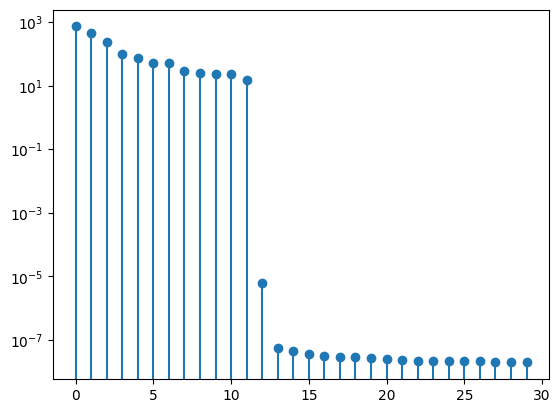

In [66]:
plt.stem(dv_sorted[:30])
plt.yscale('log')

Note that there is a large drop off between index 11 and 12.

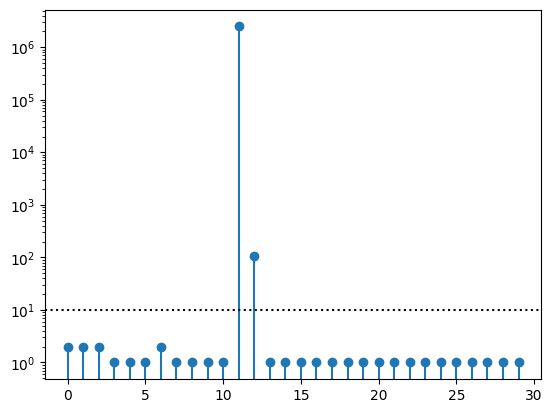

In [77]:
ratios = dv_sorted[:-1]/dv_sorted[1:]

plt.stem(np.round(ratios[:30],0).astype(int))
plt.axhline(10, c="k", linestyle=":")
plt.yscale('log')

We set `num_SVs` to be the first index plus one where this dropoff is at least one order of magnitude. The "plus one" is because Python's zero-indexing.

In [78]:
num_SVs = np.argmax(np.floor(np.log10(np.round(ratios,0).astype(int))).astype(int) > 0) + 1
num_SVs

12